In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.argv = ['']
del sys
import open3d as o3d
import numpy as np
import mrob
from project_map import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## plot 3d rectified map

In [5]:
init_pose = mrob.geometry.SE3(np.eye(4))

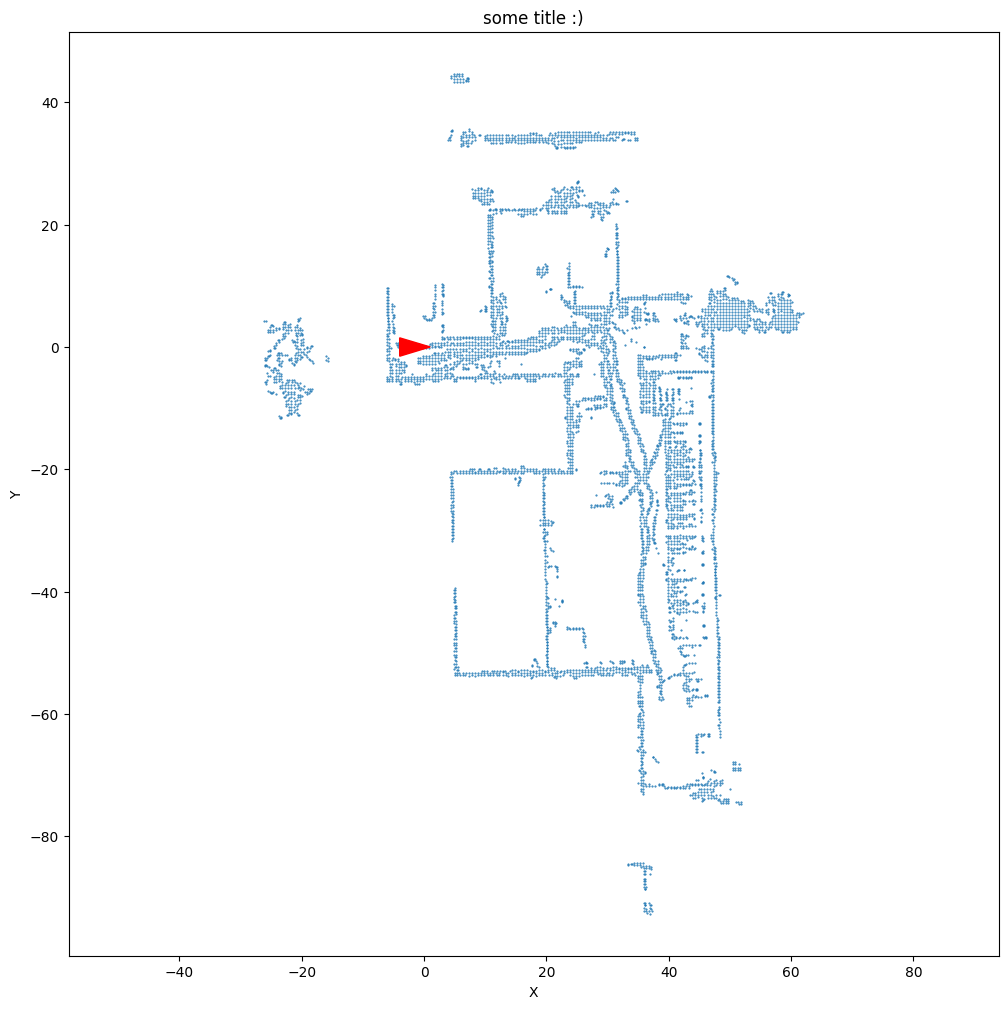

In [6]:
#before filter
Map_ch = o3d.io.read_point_cloud('./assets/map.pcd')
Map_ch.paint_uniform_color([0,0,0]) 
# o3d.visualization.draw_geometries([Map_ch, ax(np.eye(4))])


#after filter - rectifed
dT_ch = np.load('./assets/dT.npy')
Map_ch_2d = o3d.io.read_point_cloud('./assets/map_rect_2d.pcd')
Map_ch_filter = o3d.io.read_point_cloud('./assets/map_rect.pcd')

# o3d.visualization.draw_geometries([Map_ch_filter, ax(dT_ch)])

X, Y, _= np.asarray(Map_ch_2d.points).T
plot_map_pose(X, Y, init_pose, dT_ch)


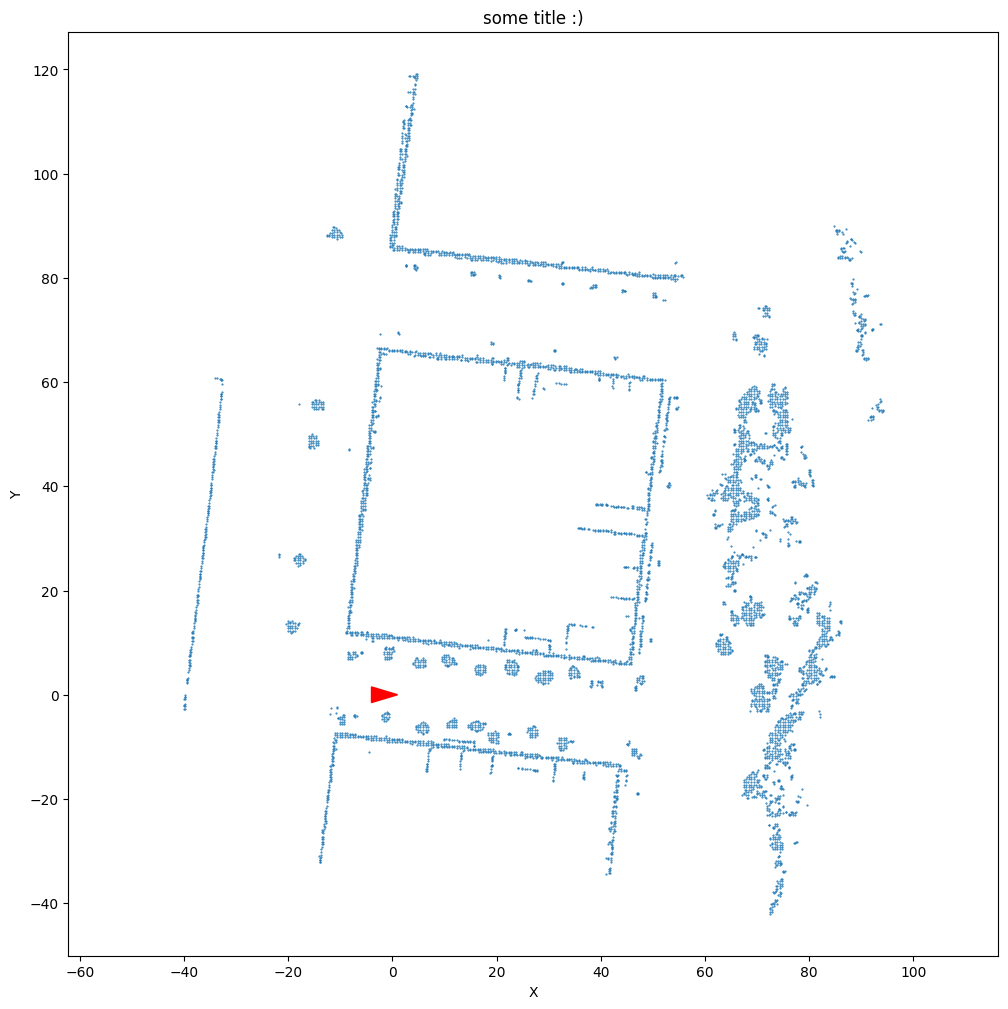

In [7]:
#before filter
Map_SK = o3d.io.read_point_cloud('./car_records/map.pcd')
Map_SK.paint_uniform_color([0,0,0]) 
# o3d.visualization.draw_geometries([Map_SK, ax(np.eye(4))])


#after filter - rectifed
dT_SK = np.load('./car_records/dT.npy')
Map_SK_2d = o3d.io.read_point_cloud('./car_records/map_rect_2d.pcd')
Map_SK_filter = o3d.io.read_point_cloud('./car_records/map_rect.pcd')

# o3d.visualization.draw_geometries([Map_SK_filter, ax(dT_SK)])
X, Y, _= np.asarray(Map_SK_2d.points).T
plot_map_pose(X, Y, init_pose, dT_SK)


In [6]:
# o3d.visualization.draw_geometries([Map_SK_filter, ax(dT_SK)])
o3d.visualization.draw_geometries([Map_SK, ax(np.eye(4))])


In [8]:
import pandas as pd
def quat_to_SE3(quat_pose):
    
    #orb3
    rot_4x1 = quat_pose[-4:]
    tra_3x1 = quat_pose[:3]

    rot = mrob.geometry.quat_to_so3(rot_4x1)
    pose = mrob.geometry.SE3(mrob.geometry.SO3(rot),tra_3x1)

    return pose


ak_poses = pd.read_csv('./car_records/odom.csv')[
                                [
                                'pose.pose.position.x',
                                'pose.pose.position.y',
                                'pose.pose.position.z',
                                'pose.pose.orientation.x',
                                'pose.pose.orientation.y',
                                'pose.pose.orientation.z',
                                'pose.pose.orientation.w',
                                ]
                                ]
ak_quat = np.asarray(ak_poses)

ak = np.zeros((ak_quat.shape[0],4,4))
for i in range(len(ak_quat)):
    ak[i,:,:] = (quat_to_SE3(ak_quat[i,:])).T() @ dT_SK


In [8]:
ak_ = [ax(i) for i in ak[::10]]
o3d.visualization.draw_geometries(ak_+[Map_SK_filter])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


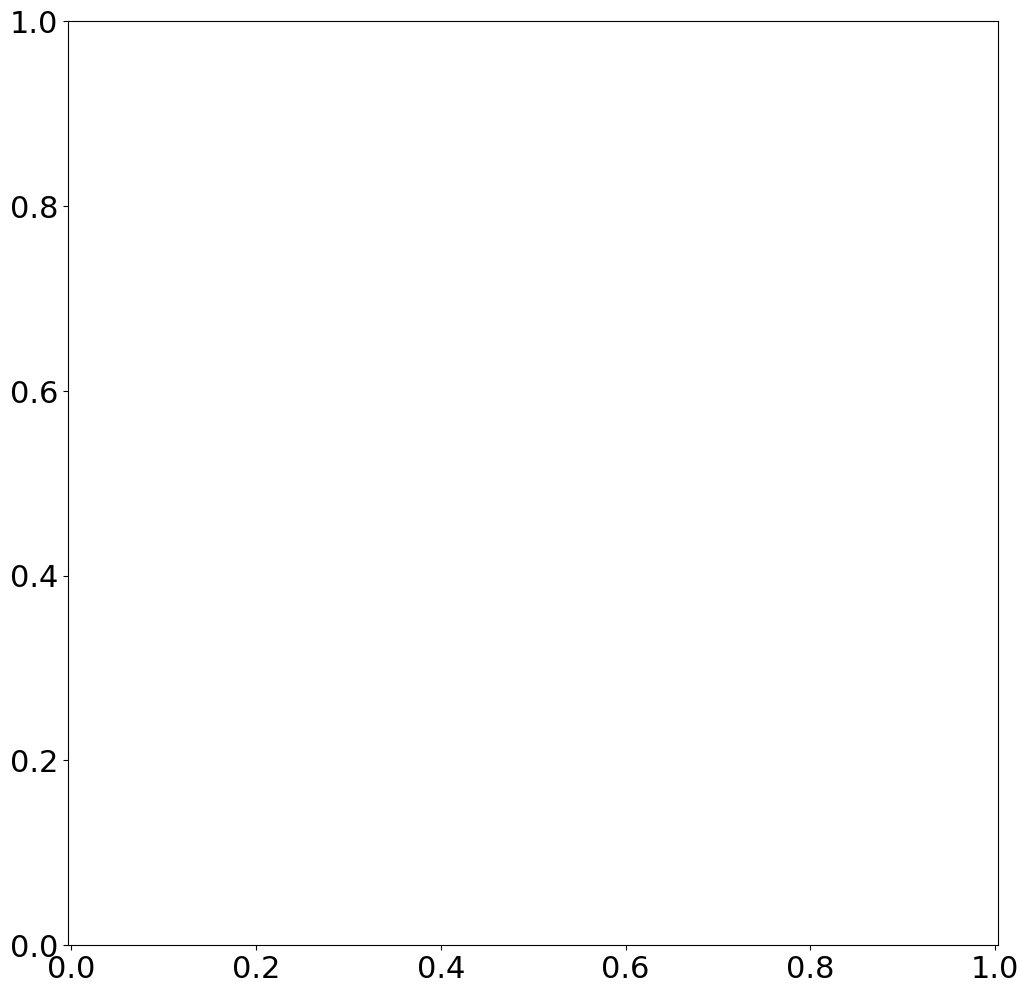

In [9]:
from tqdm import tqdm
def save_figs(dT, poses, save_path):
    
    fig, ax = plt.subplots(figsize=(12,12))
    plt.rcParams.update({'font.size': 22})

    plt.axis('equal')
    
    X, Y, _= np.asarray(Map_SK_2d.points).T
    
    dT = mrob.geometry.SE3(dT)
    for idx, t in enumerate(tqdm(poses)):
        idx_str = f'{idx:04}'
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        
          
        pose = mrob.geometry.SE3(t)
        x, y, dx, dy = pose2D(pose)
    
        ax.scatter(X, Y, marker='.', s=1)
        ax.arrow(
            x, y, dx, dy,
            width=0.1,
            alpha=1,
            color="red",
            head_width=3,
            head_length=math.sqrt((dx*5) ** 2 + (dy*5) ** 2),
            length_includes_head=True,
            head_starts_at_zero=False,
            )
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Skoltech Car Sequence')
        filename = os.path.join(save_dir, f'{idx_str}.png')
        fig.savefig(filename, format='png')

        ax.clear()




save_path = './car_records/plots/'
save_figs(dT_SK, list(ak[::5]), save_path)



In [13]:
import cv2
import os

def create_video_from_pngs(png_folder, output_video_filename, frame_rate):
    # Get a list of all PNG files in the folder
    png_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]
    
    if not png_files:
        print("No PNG files found in the folder.")
        return
    
    # Sort the PNG files by filename
    png_files.sort()
    
    # Read the first PNG file to get dimensions
    first_frame = cv2.imread(os.path.join(png_folder, png_files[0]))
    height, width, layers = first_frame.shape
    
    # Define the codec for the video (e.g., XVID)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Create a VideoWriter object
    out = cv2.VideoWriter(output_video_filename, fourcc, frame_rate, (width, height))
    
    # Write each PNG frame to the video
    for png_file in png_files:
        frame = cv2.imread(os.path.join(png_folder, png_file))
        out.write(frame)
    
    # Release the VideoWriter
    out.release()
    print(f"Video saved as {output_video_filename}")

# Example usage:
png_folder = './car_records/plots/'  # Replace with the folder containing your PNG files
output_video_filename = './car_records/output_video.mp4'  # Specify the output video filename
frame_rate = 10  # Set the frame rate for the video

create_video_from_pngs(png_folder, output_video_filename, frame_rate)


Video saved as ./car_records/output_video.mp4
